# Análisis de Clasificación Automática de Modulación  
Este notebook consolida y visualiza los resultados obtenidos con distintas arquitecturas y escenarios de canal.

**Estructura**  
1. Descubrimiento de experimentos  
2. Carga y parsing de reportes (`classification_report.json` y `effects_report.json`)  
3. DataFrame maestro  
4. Métricas agregadas + IC 95 %  
5. Visualización principal (Accuracy ± IC)  
6. Tests estadísticos (Friedman/Nemenyi o Wilcoxon)  
7. Visualizaciones adicionales  
   - Heatmap F1 por clase × escenario  
   - Curvas de efectos (SNR, fase, taps)  
   - Boxplot de accuracies  
   - Radar de robustez relativa


In [1]:
import utils.results.result_utils  as result_utils
from utils.results.sbn_style import *

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pathlib import Path
import re

%config InlineBackend.figure_format = "svg" 

# ----------------- Paths -------------------------------------
# CUSTOM_DIR             = "EarlyValidation"
CUSTOM_DIR               = "ARQs"
# CUSTOM_DIR             = "256_QAM"


RESULTS_ROOT    = Path().resolve() / "results"
FIG_OUT         = Path().resolve() / "Figures"
FIG_OUT.mkdir(parents=True, exist_ok=True)

### Declaración escenarios

In [ ]:
ARCHS = ['ARQ_1', 'ARQ_2', 'ARQ_3']
ARCHIS_NAME = {
    'ARQ_1': 'CNN-BiLSTM-Attention',
    'ARQ_2': 'Inception-Res-SE-Attention',
    'ARQ_3': 'Res-TCN-SE',
}

ESCS_BY_PARAM = {
    'snr_db': {
        'label': 'SNR (dB)',
        'constants': {
            'num_taps': 2,
            'phase_offset': {'low': 0.0, 'high': 45.0},
        },
        'escs': {
            'ESC_1': {'low': 0.0, 'high': 4.0},
            'ESC_2': {'low': 4.0, 'high': 8.0},
            'ESC_3': {'low': 8.0, 'high': 12.0},
            'ESC_4': {'low': 12.0, 'high': 16.0},
            'ESC_5': {'low': 16.0, 'high': 20.0},
        },
    },

    'num_taps': {
        'label': 'Número de multitrayectos',
        'constants': {
            'snr_db': {'low': 8.0, 'high': 12.0}, 
            'phase_offset': {'low': 0.0, 'high': 45.0}
        },
        'escs': {
            'ESC_6': {'num_tap': 1},
            'ESC_3': {'num_tap': 2},
            'ESC_7': {'num_tap': 4},
            'ESC_8': {'num_tap': 6},
        },
    },
    'phase_offset': {
        'label': 'Desfase (°)',
        'constants': {
            'snr_db': {'low': 8.0, 'high': 12.0}, 
            'num_taps': 2
        },
        'escs': {
            'ESC_3': {'low': 0.0, 'high': 45.0},
            'ESC_9': {'low': 45.0, 'high': 90.0},
            'ESC_10': {'low': 90.0, 'high': 135.0},
            'ESC_11': {'low': 135.0, 'high': 180.0},
        },
    },
}

ESCS_ORDER = {p: list(v["escs"]) for p, v in ESCS_BY_PARAM.items()}

### Resultados a mostrar (EarlyValidation, ARQs, 256_QAM)

In [ ]:


VALIDATION_RESULTS_ROOT = RESULTS_ROOT / CUSTOM_DIR
VALIDATION_FIG_OUT      = FIG_OUT      / CUSTOM_DIR
VALIDATION_FIG_OUT.mkdir(parents=True, exist_ok=True)

# 1) descubrir pares report/effects
pairs = result_utils.discover_jsons(VALIDATION_RESULTS_ROOT)
print(f"Found {len(pairs)} pairs of results and effects files.")

# 2) cargar métricas globales, por-clase y efectos
df_runs, df_classes = result_utils.load_reports(pairs)
df_metrics         = df_runs.copy()
df_eff_raw         = result_utils.load_effects(pairs)

# 3) diagnóstico rápido
print("\n→ df_metrics (global run metrics)")
display(df_metrics.head())

print("\n→ df_classes (per-class metrics)")
display(df_classes.head())

print("\n→ df_eff_raw (channel-effects bins)")
display(df_eff_raw.head())

Found 30 pairs of results and effects files.


In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(9, 4.2), sharex=True)
# for ax, m, t in zip(axes, ["accuracy", "loss"], ["Accuracy", "Loss"]):
#     sns.violinplot(data=df_runs, x="architecture", y=m,
#                    ax=ax, inner=None, palette=PALETTE_ARCH, alpha=.85)
#     sns.stripplot(data=df_runs, x="architecture", y=m,
#                   ax=ax, color="k", size=1.3, alpha=.25)
#     ax.set_title(t, weight="bold"); ax.set_xlabel(""); ax.set_ylabel("")
#     if m == "accuracy": ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# fig.tight_layout(); fig.savefig(VALIDATION_FIG_OUT/"early_violin_acc_loss.pdf")

✔  saved Figures/256_QAM/snr_db.pdf
✔  saved Figures/256_QAM/phase_offset.pdf


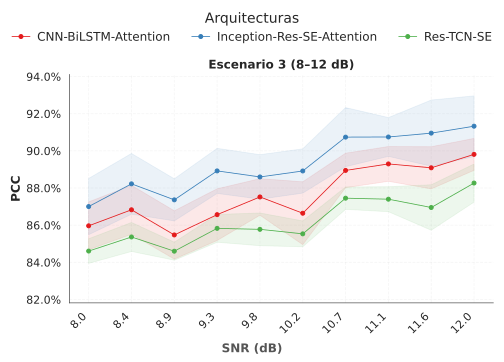

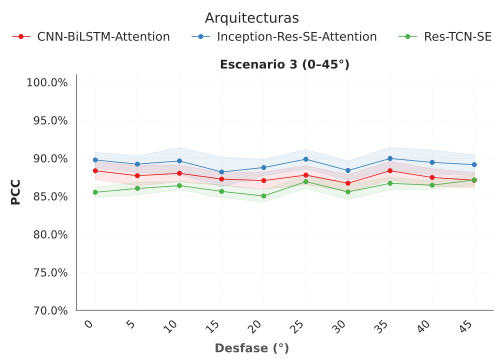

In [ ]:
# -----------------------------------------------------------
# 1 ▸  Función que normaliza bin → índice 0-9 dentro del ESC
# -----------------------------------------------------------
def bin_index(bin_label: str, esc: str, param: str) -> int:
    """
    Devuelve 0-9 según la posición del bin dentro del escenario.

    • Para SNR (4 dB por ESC):   ancho_bin = 0.4  → 10 bins.
    • Devuelve None si el label no encaja.
    """
    if param not in ["snr_db", "phase_offset"]:
        return None  # solo aplica a SNR y desfase

    # extrae límites numéricos
    lo, hi = sorted(map(float, re.findall(r"[-+]?\d*\.?\d+", bin_label)))
    esc_info = ESCS_BY_PARAM[param]["escs"][esc]
    esc_lo   = esc_info["low"]
    # distancia desde el inicio del ESC
    offset   = lo - esc_lo
    # evita problemas de redondeo
    if param == "snr_db":
        idx = int(round(offset / 0.4, 0))
    elif param == "phase_offset":
        idx = int(round(offset / 4.5, 0))
    return idx if 0 <= idx <= 9 else None

def make_esc_label(param: str, esc: str) -> str:
    """Devuelve ‘Escenario 1 (0–4 dB)’, etc."""
    info = ESCS_BY_PARAM[param]["escs"][esc]
    esc_n = esc.replace("ESC_", "Escenario ")
    if param == "snr_db":
        return f"{esc_n} ({info['low']:.0f}–{info['high']:.0f} dB)"
    if param == "num_taps":
        return f"{esc_n} ({info['num_tap']} tap{'s'*(info['num_tap']>1)})"
    if param == "phase_offset":
        return f"{esc_n} ({info['low']:.0f}–{info['high']:.0f}°)"
    return esc_n


# -----------------------------------------------------------
# 2 ▸  DataFrame con ‘bin_idx’ normalizado
# -----------------------------------------------------------
def plot_esc_params(param: str) -> None:
    esc_list  = ESCS_ORDER[param]

    df_bins = (df_eff_raw
            .loc[(df_eff_raw["param"] == param) &
                    (df_eff_raw["scenario"].isin(esc_list))]
            .copy())

    df_bins["bin_idx"] = [
        bin_index(b, esc, param) for b, esc in zip(df_bins["bin"], df_bins["scenario"])
    ]
    df_bins = df_bins.dropna(subset=["bin_idx"])
    df_bins["bin_idx"] = df_bins["bin_idx"].astype(int)

    # -----------------------------------------------------------
    # 3 ▸  Agregado: media ± IC95 por (arch, esc, bin_idx)
    # -----------------------------------------------------------

    g = (df_bins.groupby(["architecture", "scenario", "bin_idx"], as_index=False)
                .agg(mean_acc=("accuracy", "mean"),
                        std_acc =("accuracy", "std"),
                        n       =("accuracy", "size")))
    g["ci95"] = 1.96 * g["std_acc"] / np.sqrt(g["n"])

    # 2 ▸  Fig + 5 sub-ejes con separación limpia
    ylim_low = g['mean_acc'].min() - g['ci95'].max() - 0.01
    ylim_max = min(g['mean_acc'].max() + g['ci95'].max() + 0.01, 1.01)

    if param == 'phase_offset':
        ylim_low = min(0.7, ylim_low)
        ylim_max = 1.01

    if len(esc_list) > 1:
        fig, axs = plt.subplots(1, len(esc_list), figsize=(4*len(esc_list), 5), sharey=True, gridspec_kw=dict(wspace=0.00))
    else:
        fig, axs = plt.subplots(1, 1, figsize=(7, 4), sharey=True)
        axs = [axs]

    for ax, esc in zip(axs, esc_list):
        sub = g[g["scenario"] == esc]
        for i, arch in enumerate(ARCHS):
            s = sub[sub["architecture"] == arch]
            if s.empty: continue
            ax.plot(s["bin_idx"], s["mean_acc"],
                    marker="o", ms=4, lw=0.8,
                    color=arch_color_intense(i), label=ARCHIS_NAME[arch])
            ax.fill_between(s["bin_idx"],
                            s["mean_acc"] - s["ci95"],
                            s["mean_acc"] + s["ci95"],
                            color=arch_color_intense(i), alpha=.1)
        
        x_min = ESCS_BY_PARAM[param]["escs"][esc]["low"]
        x_max = ESCS_BY_PARAM[param]["escs"][esc]["high"]
        labels = [f"{x:.1f}" if param == "snr_db" else f"{x:.0f}" for x in np.linspace(x_min, x_max, 10)]
        ax.set_xticks(range(10))
        ax.set_xticklabels(labels, fontsize=11, rotation=45, ha="right")
        ax.set_title(make_esc_label(param, esc), fontsize=12, weight="bold", pad=6)
        ax.spines[['top','right']].set_visible(False)

    for ax in axs:
        ax.set_ylim(ylim_low, ylim_max)

    axs[0].set_ylabel("PCC", fontsize=12, weight="bold")
    axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # 3 ▸  Leyenda externa y título general
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        title="Arquitecturas",
        loc="upper center",
        bbox_to_anchor=(0.5, 1.2),
        ncol=len(labels), 
        frameon=False, 
        handlelength=1.5,
        handletextpad=0.6,
        columnspacing=1.8,
        fontsize=12,
        title_fontsize=14
    )
    fig.suptitle("", weight="bold", y=1.18, fontsize=18, color="#333")
    fig.text(0.5, -0.02, f"{ESCS_BY_PARAM[param]['label']}", ha="center", fontsize=12, color="#555", weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 1.07])
    out = VALIDATION_FIG_OUT / f"{param}.pdf"
    fig.savefig(out, bbox_inches="tight", dpi=300)
    print(f"✔  saved {out.relative_to(Path().resolve())}")

plot_esc_params("snr_db")
plot_esc_params("phase_offset")

✔  saved Figures/256_QAM/num_taps_by_esc_bars.pdf


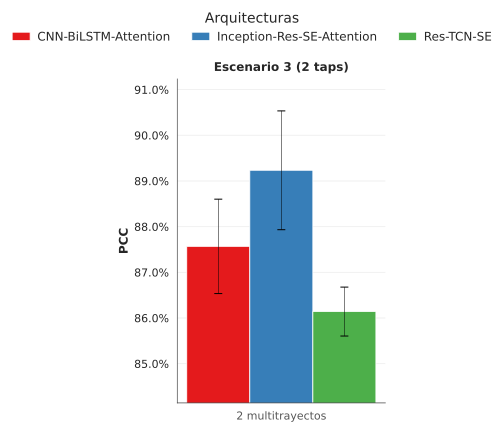

In [ ]:
def plot_num_taps_as_bars(
    df_eff_raw,
    ESCS_BY_PARAM,
    ARCHS,
    ARCHIS_NAME,
    VALIDATION_FIG_OUT
):
    param    = 'num_taps'
    esc_list = ESCS_ORDER[param] 

    # 2) Filtrar y agregar métricas
    df_taps = df_eff_raw[df_eff_raw['param'] == param].copy()
    df_taps = df_taps[df_taps['scenario'].isin(esc_list)]
    g = (
        df_taps
        .groupby(['architecture','scenario'], as_index=False)
        .agg(
            mean_acc=('accuracy','mean'),
            std_acc =('accuracy','std'),
            n       =('accuracy','size')
        )
    )
    g['ci95'] = 1.96 * g['std_acc'] / np.sqrt(g['n'])
    g['num_tap'] = g['scenario'].map(
        lambda esc: ESCS_BY_PARAM[param]['escs'][esc]['num_tap']
    )
    g = g.sort_values('num_tap')

    # 3) Prepara posiciones de barras
    n_archs = len(ARCHS)
    width   = 0.8 / n_archs
    # creamos un mapping de escenario→índice
    taps    = sorted(g['num_tap'].unique())
    pos_map = {tap:i for i,tap in enumerate(taps)}

    # 4) Crear figure con un eje por ESC
    fig, axs = plt.subplots(
        1, len(esc_list),
        figsize=(4*len(esc_list), 5),
        sharey=True,
        gridspec_kw=dict(wspace=0.00)
    )
    if len(esc_list) == 1:
        axs = [axs]

    # 5) Grid
    for ax in axs:
        ax.yaxis.grid(True, color='#bbbbbb', linestyle='-', linewidth=0.8, alpha=0.25)
        ax.xaxis.grid(False)

    # 6) Dibujar barras en cada subplot
    for ax, esc in zip(axs, esc_list):
        sub = g[g['scenario'] == esc]
        tap = ESCS_BY_PARAM[param]['escs'][esc]['num_tap']
        base_x = pos_map[tap]
        for i, arch in enumerate(ARCHS):
            s = sub[sub['architecture'] == arch]
            if s.empty:
                continue
            x = base_x - 0.4 + i*width + width/2
            ax.bar(
                x,
                s['mean_acc'].iloc[0],
                width=width,
                yerr=s['ci95'].iloc[0:1],
                capsize=4,
                label=ARCHIS_NAME[arch],
                color=arch_color_intense(i),
                edgecolor=None
            )

        # 7) Etiqueta x y título
        ax.set_xticks([base_x])
        if tap == 1:
            xlabel = "Trayectoria única"
        else:
            xlabel = f"{tap} multitrayectos"
        ax.set_xticklabels([xlabel], fontsize=11, color='#555')
        ax.set_title(
            make_esc_label(param, esc),
            fontsize=12, weight='bold', pad=8
        )
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        y_min = g['mean_acc'].min() - 0.02
        y_max = g['mean_acc'].max() + 0.02
        ax.set_ylim(y_min, y_max)

    # 8) Etiqueta Y
    axs[0].set_ylabel('PCC', fontsize=12, weight='bold')
    axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # 9) Leyenda común arriba
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        title='Arquitecturas',
        loc='upper center', bbox_to_anchor=(0.5, 1.2),
        ncol=len(labels), frameon=False,
        handlelength=1.5, handletextpad=0.6, columnspacing=1.8,
        fontsize=12, title_fontsize=14
    )

    plt.tight_layout(rect=[0, 0, 1, 1.06])
    out = Path(VALIDATION_FIG_OUT) / 'num_taps_by_esc_bars.pdf'
    fig.savefig(out, bbox_inches='tight', dpi=300)
    print(f"✔  saved {out.relative_to(Path().resolve())}")

# Ejecución
plot_num_taps_as_bars(
    df_eff_raw,
    ESCS_BY_PARAM,
    ARCHS,
    ARCHIS_NAME,
    VALIDATION_FIG_OUT
)


In [ ]:
import pandas as pd

# Ejemplo: Supongamos que ya cargaste tus classification_report.json en un DataFrame llamado df_reports
# con columnas: 'scenario', 'architecture', 'accuracy', 'loss'.

# Paso 1: Agrupar por escenario y arquitectura para calcular media y desviación estándar
agg = df_metrics.groupby(['scenario', 'architecture']).agg(
    acc_mean=('accuracy', 'mean'),
    acc_std=('accuracy', 'std'),
    loss_mean=('loss', 'mean'),
    loss_std=('loss', 'std')
).reset_index()

# Paso 2: Formatear cadenas con ± para LaTeX
agg['Acc'] = agg.apply(lambda x: f"{x.acc_mean*100:.2f} ± {x.acc_std*100:.2f}", axis=1)
agg['Loss'] = agg.apply(lambda x: f"{x.loss_mean:.3f} ± {x.loss_std:.3f}", axis=1)

# Paso 3: Pivotar resultados para construir la tabla
pivot_acc = agg.pivot(index='scenario', columns='architecture', values='Acc')
pivot_loss = agg.pivot(index='scenario', columns='architecture', values='Loss')

# Paso 4: Combinar Acc y Loss en LaTeX
latex_rows = []
for scen in pivot_acc.index:
    row = [scen]
    for arch in pivot_acc.columns:
        row.append(pivot_acc.loc[scen, arch])
        row.append(pivot_loss.loc[scen, arch])
    latex_rows.append(row)

# Definir encabezados
headers = ['Condición']
for arch in pivot_acc.columns:
    headers.extend([f"{arch} Acc (\\%)", f"{arch} Loss"])

df_table = pd.DataFrame(latex_rows, columns=headers)

# Imprimir LaTeX de la tabla final
print(df_table.to_latex(index=False, escape=False))


\begin{tabular}{lllllll}
\toprule
Condición & ARQ_1 Acc (\%) & ARQ_1 Loss & ARQ_2 Acc (\%) & ARQ_2 Loss & ARQ_3 Acc (\%) & ARQ_3 Loss \\
\midrule
ESC_3 & 87.57 ± 1.67 & 0.338 ± 0.075 & 89.24 ± 2.11 & 0.318 ± 0.042 & 86.14 ± 0.87 & 0.314 ± 0.028 \\
\bottomrule
\end{tabular}

